In [30]:
import torch
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score

In [2]:
import torchvision.transforms.functional as tvf

In [3]:
import torchvision

In [4]:
sys.path.append('/home/colin/covid-blood/')
model_id = '16hb50e4'
from config import get_config
from torchvision import transforms
from utils import setup_torch, get_covid_transforms, load_model
import wandb
from dataloader import load_all_patients, load_pbc_data
from models.imagenet import get_model
from models.multi_instance import AttentionModel, GatedAttentionModel, SimpleMIL
from mil_trainer import ClassificationTrainer
from torch import optim
import warnings

In [5]:
def denormalize_image(image, mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    image = image.clone()
    image = image * torch.tensor(std).view(3, 1, 1)
    image = image + torch.tensor(mean).view(3, 1, 1)
    return image.permute(1, 2, 0)

In [7]:
data_transforms = get_covid_transforms(image_size=224, center_crop_amount=224)
train_loader, val_loader, test_loader = load_all_patients(train_transforms=data_transforms['train'],
                                                              test_transforms=data_transforms['val'],
                                                              batch_size=1,
                                                              fold_number=0,
                                                              group_by_patient=True,
                                                              weighted_sample=True,
                                                              random_sample=False)

156it [00:00, 6718.67it/s]
39it [00:00, 5312.00it/s]
39it [00:00, 8005.57it/s]

0.5 blank
reading cache


In [8]:
model = SimpleMIL(
        backbone_name='resnet50',
        num_classes=2,
        pretrained_backbone=False,
        instance_hidden_size=1024,
        hidden_size=1024
    )

In [9]:
loaded = load_model(model, model_id=model_id)

In [21]:
len(test_loader)

39

In [22]:
from tqdm.notebook import tqdm

In [23]:
all_images = []
all_labels = []
all_preds = []
for images, labels in tqdm(test_loader):
    all_images = images.view(-1, 3, 224, 224)
    with torch.no_grad():
        features = loaded.backbone(all_images.view(-1, 3, 224, 224))
        attention = loaded.attention(features)
        attention = torch.transpose(attention, 1, 0)
        attention_weights = F.softmax(attention, dim=1)
        aggregated_features = torch.mm(attention_weights, features)
        mil_classification = loaded.mil_classifier(aggregated_features)
        all_preds.append(mil_classification)
        all_labels.append(labels)

In [25]:
labels = [int(al) for al in all_labels]

In [29]:
confs = [F.softmax(mil, dim=1)[0,1] for mil in all_preds]

In [31]:
roc_auc_score(labels, confs)

0.8552631578947368

In [85]:
all_images = torch.cat([v.view(-1, 3, 224, 224) for v in all_images])

In [13]:
with torch.no_grad():
    features = loaded.backbone(all_images.view(-1, 3, 224, 224))
    attention = loaded.attention(features)
    attention = torch.transpose(attention, 1, 0)
    attention_weights = F.softmax(attention, dim=1)
    aggregated_features = torch.mm(attention_weights, features)
    mil_classification = loaded.mil_classifier(aggregated_features)

In [19]:
mil_classification

tensor([[-0.7282,  0.7389]], grad_fn=<AddmmBackward>)

In [15]:
len(attention[0])

127

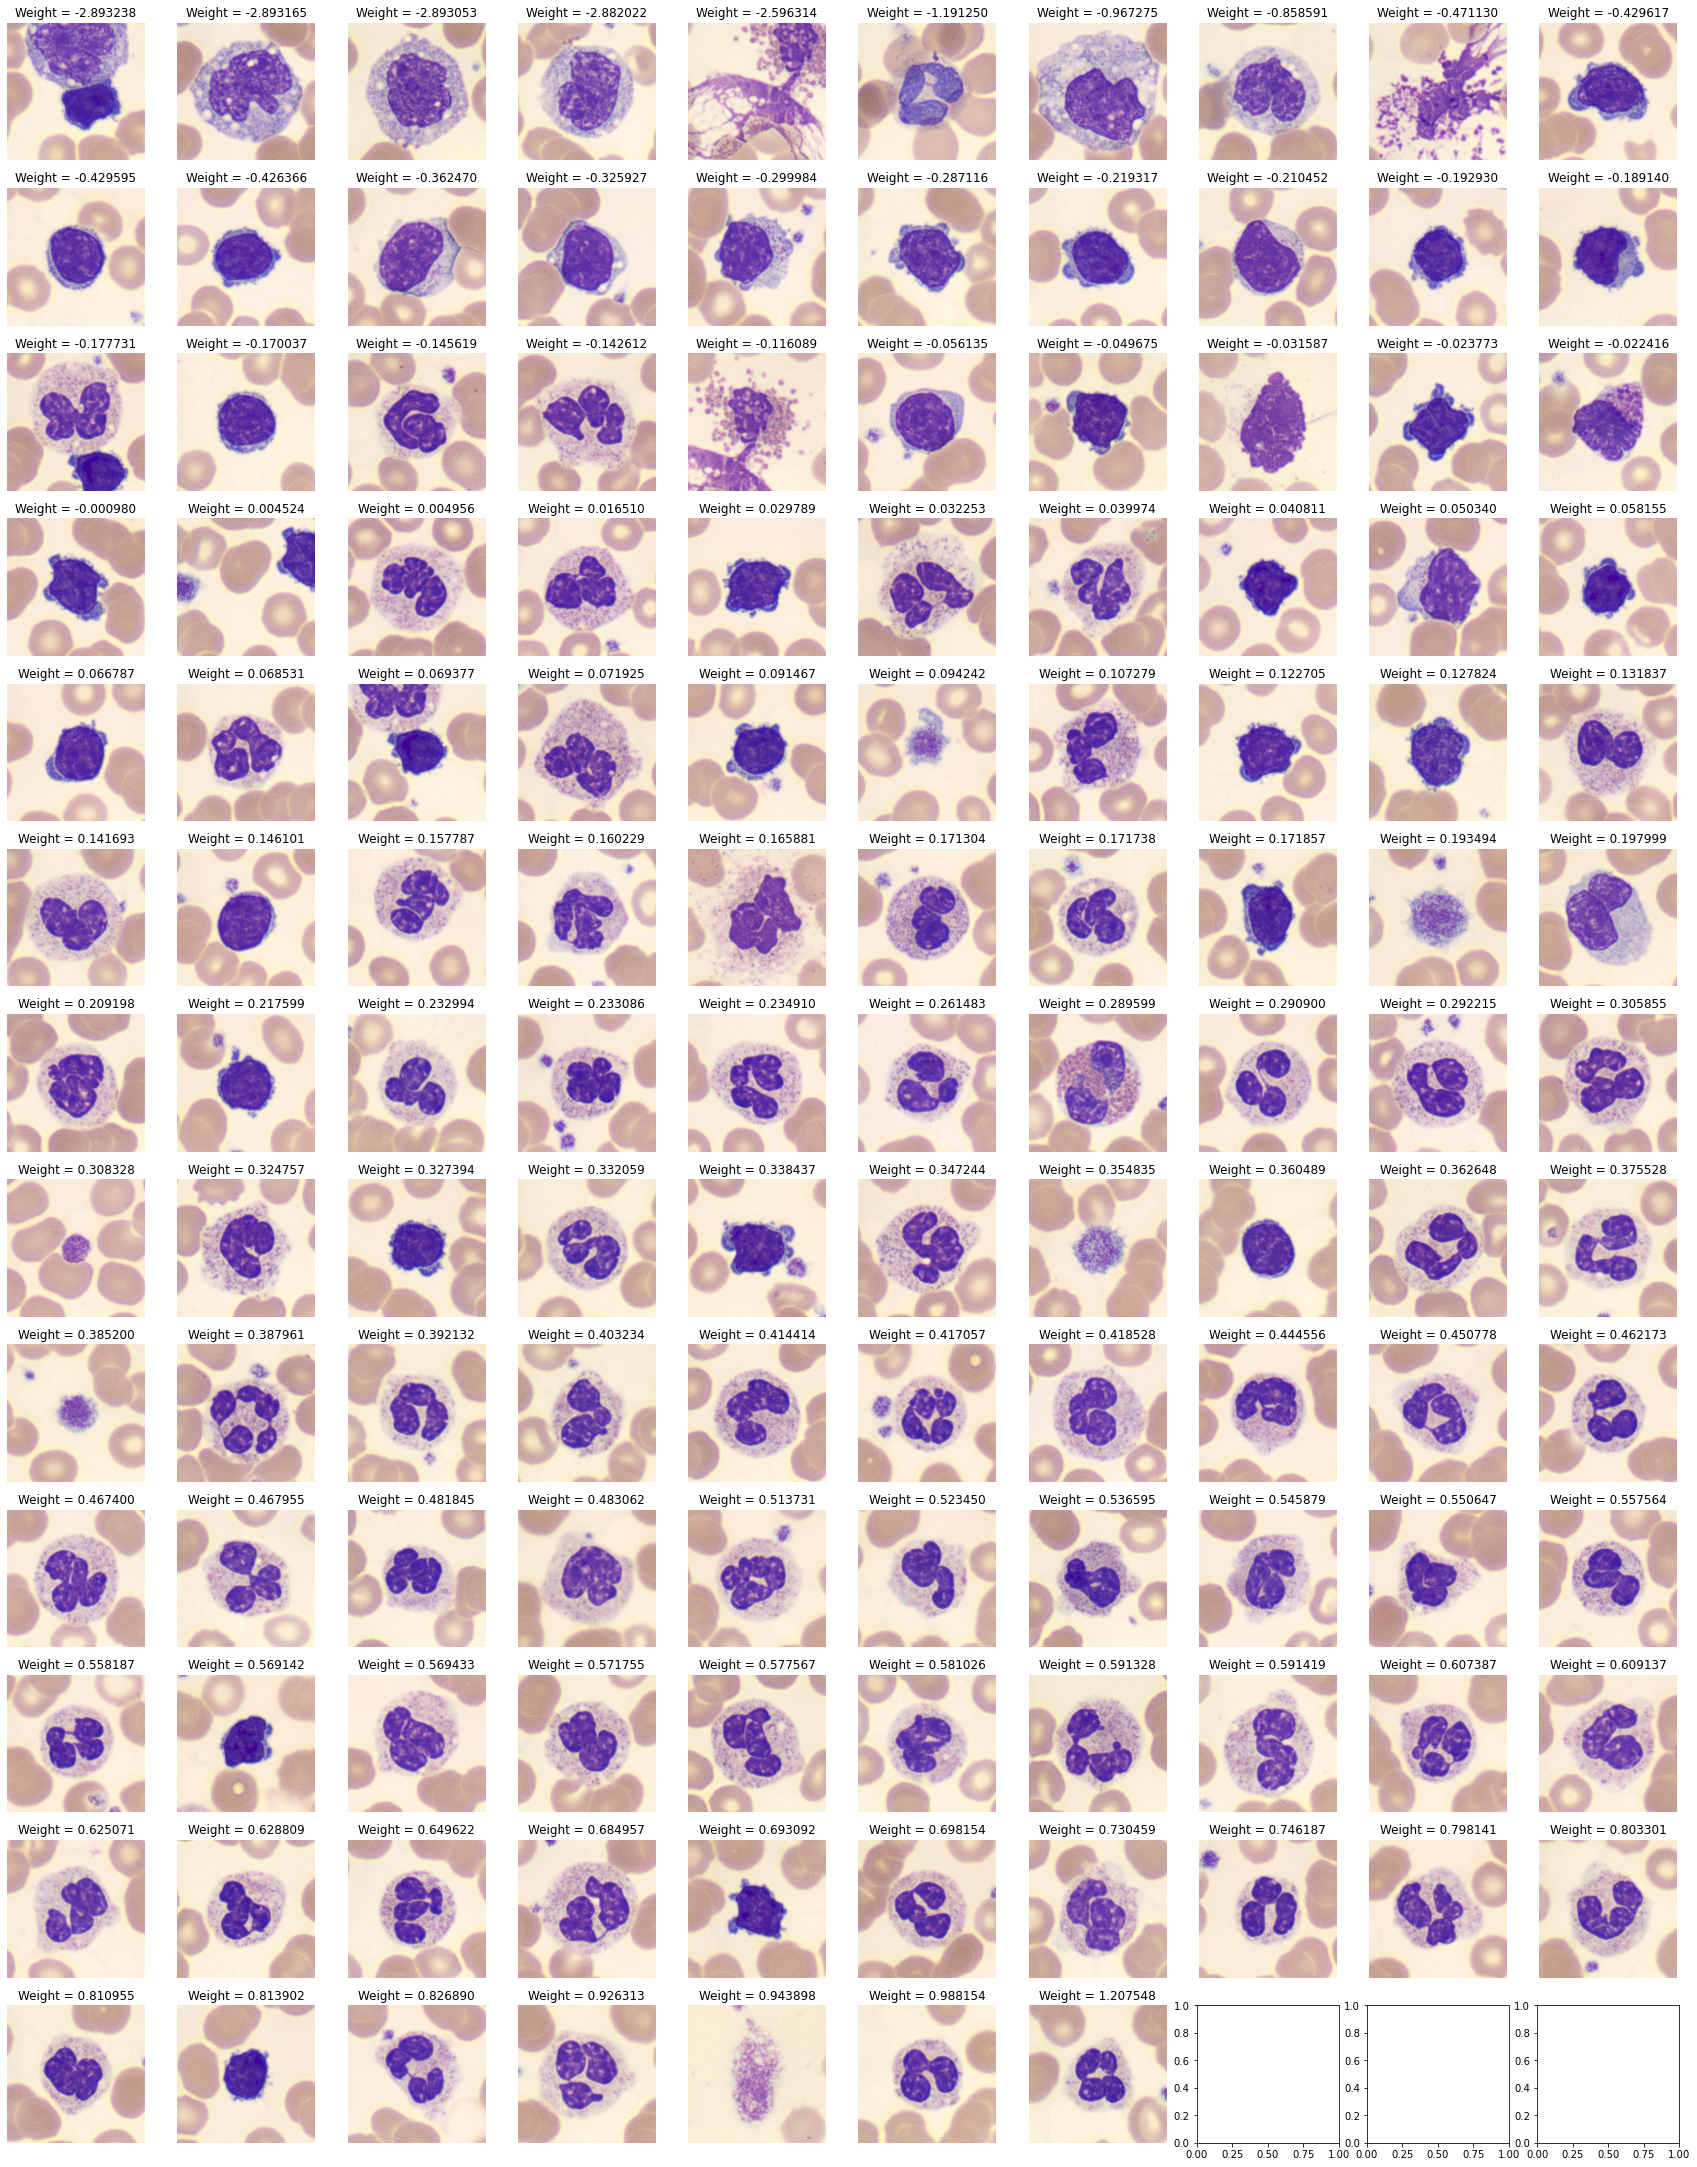

In [16]:
nrows = 13
fig, axs = plt.subplots(nrows=nrows, ncols=10, figsize=(30, 3*nrows))
argsorted = list(np.argsort(attention[0]))
for i in range(len(argsorted)):
    row = i // 10
    col = i % 10
    ax = axs[row,col]
    
    arg = argsorted[i]
    weight = attention[0,arg]
    image = denormalize_image(all_images[arg])
    
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Weight = {weight:2f}")

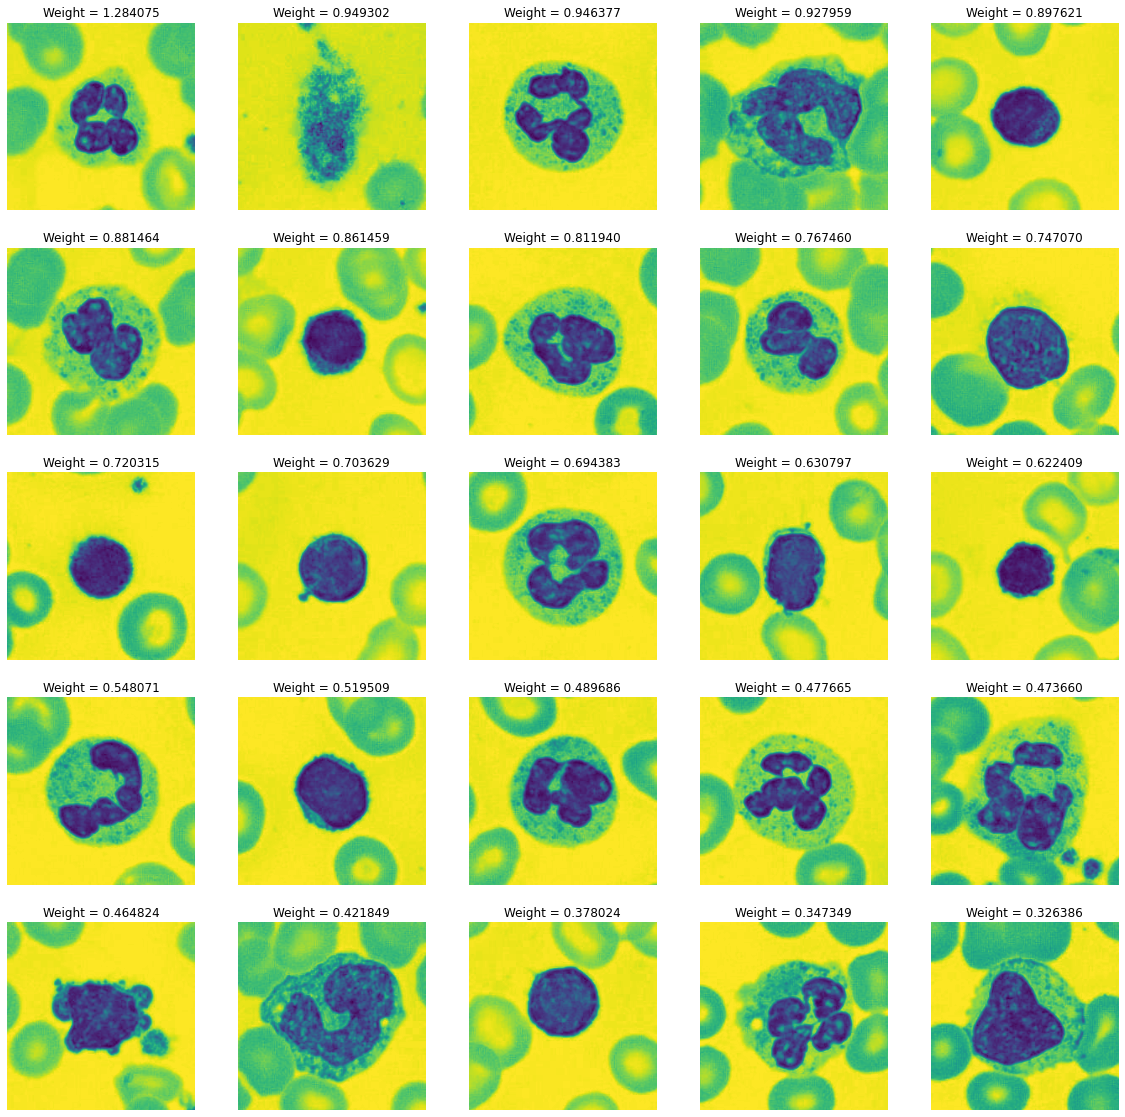

In [64]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
argsorted = list(np.argsort(attention[0]))[::-1]
for i in range(25):
    arg = argsorted[i]
    ax = axs[i//5, i%5]
    weight = attention[0,arg]
    image = all_images[arg,0]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Weight = {weight:2f}")

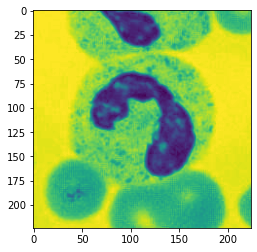

In [19]:
plt.imshow(images[0,0,0])